In [44]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import csv
import visJS2jupyter.visualizations as visualizations
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [45]:
# cleaning dataframe
def clean_df(df):
  df.columns = df.columns.str.replace(r'_nonpart_part', '')
  df1 = df.copy()
  df1['index'] = df1.index
  contact_type_list = ['index', 'friend',	'workmate',	'neighbour',	'familymember',	'partner',	'colleague_association',	'other']
  df1 = df1[contact_type_list]
  df1 = df1.set_index('index').dot(df1.columns[1:] + ', ').str[:-2].reset_index(name='contact_type')
  df_all = pd.concat([df, df1], axis = 1)
  final_columns = ['sender_id','receiver_id','contact_type','frequency','contact_years','trust']
  final_df = df_all.assign(**{col : 'NA' for col in final_columns if col not in df_all.columns})[final_columns]
  final_df = final_df[['sender_id','receiver_id','contact_type','frequency','contact_years','trust']]
  final_df = final_df[final_df['sender_id'].notna()]
  final_df = final_df[final_df['receiver_id'].notna()]
  final_df['sender_id'] = final_df['sender_id'].astype(int)
  final_df['receiver_id'] = final_df['receiver_id'].astype(int)
  return final_df 

In [46]:
# agro participating farmers connection
part_part_df = pd.read_csv('data/Edges_agroconcept_complete.csv',sep=";")
part_part_df = clean_df(part_part_df)

part_part_df.head(2)

,sender_id,receiver_id,contact_type,frequency,contact_years,trust
0,1,2,colleague_association,1,NA,4
1,1,20,"workmate, colleague_association",2,NA,4


In [12]:
# agro participating farmers with external connections- the extrenal connection ID looks similar to farmers ID, have a find a way to filter them
part_others_df = pd.read_csv('data/Edges_agroconcept_and_external_contacts.csv',sep=";")
part_others_df = clean_df(part_others_df)
part_others_df.head(2)

,sender_id,receiver_id,contact_type,frequency,contact_years,trust
0,1,2,colleague_association,1,NA,4
1,1,29,other,2,NA,4


In [13]:
# non participating farmers with non participating farmers
non_non_df = pd.read_csv('data/Edges_nonpart_all.csv',sep=";")
non_non_df = clean_df(non_non_df)
non_non_df.head(2)

,sender_id,receiver_id,contact_type,frequency,contact_years,trust
0,57,82,"friend, workmate",3.0,NaN,4.0
1,57,83,workmate,2.0,NaN,4.0


In [14]:
# non participating farmers with agro participating farmers
non_part_df = pd.read_csv('data/Edges_nonpart_to_agroconcept.csv',sep=";")
non_part_df = clean_df(non_part_df)
non_part_df.head(2)


,sender_id,receiver_id,contact_type,frequency,contact_years,trust
0,57,21,workmate,1.0,10,NA
1,58,28,"workmate, other",2.0,50,NA


In [16]:
# grouping farmers and survey responders

# agro participating farmers ID
att_part_df = pd.read_csv('data/Atts_agroconcept_int.csv',sep=";")
part_list = att_part_df['ego_id'].tolist()

# agro participating farmers ID
att_non_df = pd.read_csv('data/Atts_nonpart_int.csv',sep=";")
non_list = att_non_df['ego_id_nonpart'].tolist()
print(part_list, non_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28] [57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]


In [17]:
all_farmers_df = pd.concat([part_part_df, part_others_df, non_non_df, non_part_df])
all_farmers_df['participating'] = np.where( all_farmers_df['sender_id'].isin(part_list),'Yes'
, np.where((all_farmers_df['sender_id'].isin(non_list)) & (~all_farmers_df['sender_id'].isin(part_list)), 'No', 'Others' ))
# all_farmers_df.isna().sum() # checking if there are null values in sender_id or receiver_id columns
all_farmers_df = all_farmers_df.drop_duplicates(subset=['sender_id','receiver_id'])
all_farmers_df.head()

,sender_id,receiver_id,contact_type,frequency,contact_years,trust,participating
0,1,2,colleague_association,1.0,NA,4,Yes
1,1,20,"workmate, colleague_association",2.0,NA,4,Yes
2,1,26,"workmate, colleague_association",1.0,NA,4,Yes
3,1,14,"workmate, colleague_association",2.0,NA,4,Yes
4,1,15,"workmate, neighbour, colleague_association",2.0,NA,4,Yes


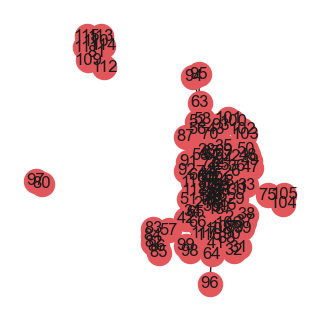

In [50]:
G = networkx.from_pandas_edgelist(all_farmers_df, 'sender_id', 'receiver_id'
# ,create_using= networkx.DiGraph()
)
sns.set(rc={"figure.figsize": (3, 3)})
font_dict = {"fontsize": 10}

networkx.draw(
    G,
    pos=networkx.fruchterman_reingold_layout(G),
    with_labels=True,
    # node_size=node_size,
    node_color="#e1575c",
    # edge_color=edge_colours,
    # width=edge_width,
)
# plt.title("Asset price correlations", fontdict=font_dict)
plt.show()

Test output of the plotly visualization below


In [47]:
G = networkx.random_geometric_graph(200, 0.125)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

We have used the reference from https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html#network-with-responsive-highlighting for the following visualizations. 

In [22]:
G = networkx.from_pandas_edgelist(part_part_df, 'sender_id', 'receiver_id')

# Calculate degree for each node and add as node attribute
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

# Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

# Calculate communities
communities = greedy_modularity_communities(G)

# Create empty dictionaries
modularity_class = {}
modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    for name in community: 
        modularity_class[name] = community_number
        modularity_color[name] = Spectral8[community_number]

# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G, modularity_class, 'modularity_class')
networkx.set_node_attributes(G, modularity_color, 'modularity_color')

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Participating Farmers Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Farmer ID", "@index"),
      # ("Farmer ID", "@sender_id"),
        ("Degree", "@degree"),
         ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

    #Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

show(plot)
# save(plot, filename=f"{title}.html")
output_notebook()

Loading BokehJS ...

In [ ]:
G = networkx.from_pandas_edgelist(non_part_df, 'sender_id', 'receiver_id'
,create_using= networkx.DiGraph()
)

# Calculate degree for each node and add as node attribute
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

# Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

# Calculate communities
communities = greedy_modularity_communities(G)

# Create empty dictionaries
modularity_class = {}
modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    for name in community: 
        modularity_class[name] = community_number
        modularity_color[name] = Spectral8[community_number]

# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G, modularity_class, 'modularity_class')
networkx.set_node_attributes(G, modularity_color, 'modularity_color')

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Non-participating Farmers Interaction with Participating Farmers Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Farmer ID", "@index"),
        ("Degree", "@degree"),
         ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

show(plot)
# save(plot, filename=f"{title}.html")
output_notebook()

In [ ]:
part_colour = dict.fromkeys(all_farmers_df.receiver_id.tolist() + all_farmers_df.sender_id.tolist())
for key, value in part_colour.items():
    # print(key, value)
    if key in part_list:
        part_colour[key] = '#a4d2d0' # green
    elif key in non_list:
        part_colour[key] = '#d2a4a6' # red
    else:
        part_colour[key] = '#e9e3ae' # yellow

In [ ]:
G = networkx.from_pandas_edgelist(all_farmers_df, 'sender_id', 'receiver_id')

# Calculate degree for each node and add as node attribute
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

# Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

# Calculate communities
communities = greedy_modularity_communities(G)
communities = communities[:-1]

# part_colour = dict.fromkeys(all_farmers_df.receiver_id.tolist().append(all_farmers_df.sender_id.tolist()))
# for key, value in part_colour.items():
#     # print(key, value)
#     if key in part_list:
#         part_colour[key] = '#a4d2d0' # green
#     elif key in non_list:
#         part_colour[key] = '#d2a4a6' # red
#     else:
#         part_colour[key] = '#e9e3ae' # yellow

# Create empty dictionaries
modularity_class = {}
# modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    for name in community: 
        modularity_class[name] = community_number
        # modularity_color[name] = Spectral8[community_number]

# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G, modularity_class, 'modularity_class')
networkx.set_node_attributes(G, part_colour, 'part_colour')

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'part_colour'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'All Farmers Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Farmer ID", "@index"),
        ("Degree", "@degree"),
         ("Modularity Class", "@modularity_class"),
        ("Participating Color", "$color[swatch]:part_colour"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

show(plot)
# save(plot, filename=f"{title}.html")
output_notebook()